# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* *Rafael Bischof*
* *Jeniffer Lima Graf*
* *Alexander Sanchez*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [39]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [3]:
components = nx.read_adjlist("../data/components.graph", create_using=nx.DiGraph())
absorbing = nx.read_adjlist("../data/absorbing.graph", create_using=nx.DiGraph())

In [28]:
def page_counts(G, iterations):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0:
            n = np.random.choice(neighbours)
        
    return pages_count

In [33]:
def print_page_counts(counts):
    for i in range(len(counts)):
        print(i, ':', counts[i])

In [35]:
iterations = 500

print_page_counts(page_counts(components, iterations))

0 : 142.0
1 : 142.0
2 : 142.0
3 : 74.0
4 : 0.0
5 : 0.0
6 : 0.0
7 : 0.0


In [36]:
print_page_counts(page_counts(absorbing, iterations))

0 : 0.0
1 : 500.0
2 : 0.0
3 : 0.0
4 : 0.0


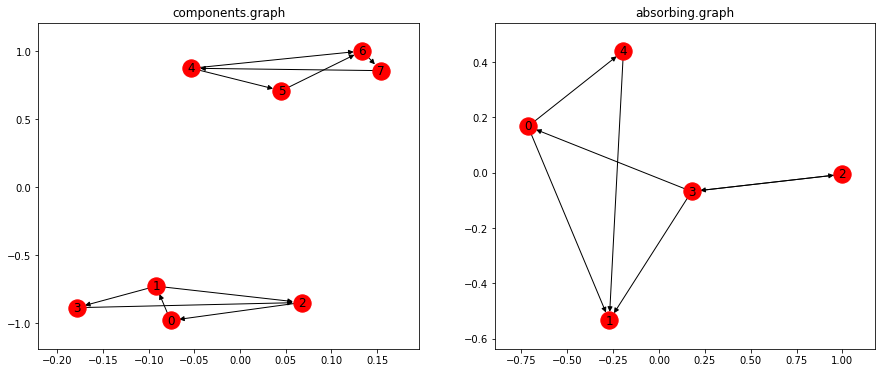

In [49]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("components.graph")
nx.draw_networkx(components, arrows=True)

plt.subplot(1,2,2)
plt.title("absorbing.graph")
nx.draw_networkx(absorbing, arrows=True)

### Explanation
The components graph has two separate connected components. Therefore the random surfer will never leave the component that it randomly selected at the start.<br>
The absorbing graph has (as its name says) an absorbing node (node 1). Once the random surfer reaches this node, it will never leave it again.

#### Exercise 2.13

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

---

### 2.4.3 Gaming the system

#### Exercise 2.15